In [1]:
import os
import nltk
import nltk.tokenize
import re
import unidecode
import collections
import numpy as np
import csv
import matplotlib.pyplot as plt


In [2]:
nltk.download('punkt', quiet=True)

True

In [3]:
n = 142 # Choose a number for a song to inspect.

In [4]:
def read_data(csvfile):
	# Result: list (= row) of lists, without header.
	data = []
	headers = True
	with open(csvfile) as stream:
		reader = csv.reader(stream, delimiter=',')
		for row in reader:
			if not headers:
				data.append(row)

			headers = False

	return data

In [5]:
liedjesData = np.array(read_data('../../data/liedjes/liedjes.csv')) # create np.array to be able to order lexicographically
liedjesData = liedjesData[liedjesData[:, 1].argsort()] # order lexicographically on identifier just like the textlist
print(liedjesData[n])

['amsterdam1849' 'amsterdam1849-feestliederen1861'
 'amsterdam1849-feestliederen1861-06' 'Feestlied' 'Wien Neerlands bloed'
 '1861' 'J. Breeman' 'amsterdam1849']


In [6]:
def getlistOfTexts(rootdir):
    # input: directory with (subdirectory with) TXT-files to be handled
	# output: list of files lexicographically ordered on path-name

    files_all = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not file.endswith('.txt'):
                continue
            fn = os.path.join(subdir, file)
            files_all.append(fn)

    files_all = sorted(files_all)
    return files_all

liedjesList = getlistOfTexts('../../data/liedjes')

In [7]:
print(liedjesList[n])

../../data/liedjes/amsterdam1849-feestliederen1859/amsterdam1849-feestliederen1859-09.txt


In [8]:
def texts2list(listOfTexts):
	# input: list of files lexicographically ordered on path-name
    # output: list of texts

	texts = []
	for file in listOfTexts:
		with open(file) as stream:
			text = stream.read()
		texts.append(text)

	return texts

liedjes = texts2list(liedjesList)

In [9]:
print(liedjes[n])

Hulde-lied

Zie zoo, deez’ feestdag is weêr daar,
En ziet, wij zijn van zessen klaar ,
Om vrolijk feest te vieren, 
Wie is er. nu niet blij van geest,
Op 't vrolijk Koppermaandagfeest ?
Wie moet het meest het sieren? 

Is t niet vriend BREEMAN, die altijd,
Zijn zorg heeft aan de zaak gewijd,
Ons menig uur wou geven; 
Hij ijvert steeds voor deze Kring,
Voor ons, zijn vrienden, onderling,
Dit is zijn eenigst-streven 

Daarom zij hem dan in dit uur,
Bezielt met ’t reinste vriendschapsvuur ,
Een danklied aangeheven; (bés)
Hij toch is ’t hoofd van dit ons feest,
Wij wenschen hem dan blij van geest.
Lang voor deez’ Kring te leven 

Dat ieder Kopperfeestgetij,
Ook door zijn werk vervrolijkt zij,
Waar meu mag roem op dragen; 
Zoo komen wij steeds jaar op jaar,
Is deze feestdag dan weêr daar,
Op nieuw wat van hem vragen 



In [10]:
def is_punctuation(string):
	# Result: A boolean for being a punctuation mark or not
	return re.compile(r'[^\w\s]+$').match(string) is not None

def remove_diacritics(string):
	# Result: A string without diacritics (accents)
	return unidecode.unidecode(string)

def preprocess_text(string):
	# Result: list of tokens in a string (= "tokenized corpus")
	string = string.lower()
	tokens = nltk.tokenize.word_tokenize(string, language="dutch")
	tokens = [token for token in tokens if not is_punctuation(token)]
	tokens = [remove_diacritics(token) for token in tokens]

	return tokens

tokenized_liedjes = [preprocess_text(liedje) for liedje in liedjes]

In [11]:
print(tokenized_liedjes[n])

['hulde-lied', 'zie', 'zoo', 'deez', 'feestdag', 'is', 'weer', 'daar', 'en', 'ziet', 'wij', 'zijn', 'van', 'zessen', 'klaar', 'om', 'vrolijk', 'feest', 'te', 'vieren', 'wie', 'is', 'er', 'nu', 'niet', 'blij', 'van', 'geest', 'op', "'t", 'vrolijk', 'koppermaandagfeest', 'wie', 'moet', 'het', 'meest', 'het', 'sieren', 'is', 't', 'niet', 'vriend', 'breeman', 'die', 'altijd', 'zijn', 'zorg', 'heeft', 'aan', 'de', 'zaak', 'gewijd', 'ons', 'menig', 'uur', 'wou', 'geven', 'hij', 'ijvert', 'steeds', 'voor', 'deze', 'kring', 'voor', 'ons', 'zijn', 'vrienden', 'onderling', 'dit', 'is', 'zijn', 'eenigst-streven', 'daarom', 'zij', 'hem', 'dan', 'in', 'dit', 'uur', 'bezielt', 'met', 't', 'reinste', 'vriendschapsvuur', 'een', 'danklied', 'aangeheven', 'bes', 'hij', 'toch', 'is', 't', 'hoofd', 'van', 'dit', 'ons', 'feest', 'wij', 'wenschen', 'hem', 'dan', 'blij', 'van', 'geest', 'lang', 'voor', 'deez', 'kring', 'te', 'leven', 'dat', 'ieder', 'kopperfeestgetij', 'ook', 'door', 'zijn', 'werk', 'vervrol

In [12]:
def extract_vocabulary(tokenized_corpus, min_count=1, max_count=float('inf')):
	# Result: list of unique words derived from a list of lists of strings
	vocabulary = collections.Counter()
	for document in tokenized_corpus:
		vocabulary.update(document)
	vocabulary = { 
		word for word, count in vocabulary.items()
		if count >= min_count and count <= max_count
	}

	return sorted(vocabulary)

liedjesVocabulary = extract_vocabulary(tokenized_liedjes, min_count=2)
# print(liedjesVocabulary)

In [13]:
def corpus2dtm(tokenized_corpus, vocabulary):
	# Result: Document Term Matrix: 
	# rows being documents in tokenized_corpus, columns being the words in vocabulary, 
	# values being the count of the word in the document
	document_term_matrix = []
	for document in tokenized_corpus:
		document_counts = collections.Counter(document)
		row = [document_counts[word] for word in vocabulary]
		document_term_matrix.append(row)

	return document_term_matrix

dtm_liedjes = np.array(corpus2dtm(tokenized_liedjes, liedjesVocabulary))

In [14]:
# print vector of song $n
for i in range(len(dtm_liedjes[n])):
    if dtm_liedjes[n][i] > 0:
        print(liedjesVocabulary[i],dtm_liedjes[n][i])

't 1
aan 1
aangeheven 1
altijd 1
bezielt 1
blij 2
breeman 1
daar 2
daarom 1
dan 3
danklied 1
dat 1
de 1
deez 2
deze 2
die 1
dit 3
door 1
dragen 1
een 1
en 1
er 1
feest 2
feestdag 2
geest 2
geven 1
gewijd 1
heeft 1
hem 3
het 2
hij 2
hoofd 1
ieder 1
in 1
is 6
jaar 2
klaar 1
komen 1
kopperfeestgetij 1
koppermaandagfeest 1
kring 2
lang 1
leven 1
mag 1
meest 1
menig 1
met 1
moet 1
niet 2
nieuw 1
nu 1
om 1
onderling 1
ons 3
ook 1
op 4
reinste 1
roem 1
sieren 1
steeds 2
t 3
te 2
toch 1
uur 2
van 5
vervrolijkt 1
vieren 1
voor 3
vragen 1
vriend 1
vrienden 1
vriendschapsvuur 1
vrolijk 2
waar 1
wat 1
weer 2
wenschen 1
werk 1
wie 2
wij 3
wou 1
zaak 1
zessen 1
zie 1
ziet 1
zij 2
zijn 5
zoo 2
zorg 1


In [15]:
document_distance_matrix = []
all_values = []
for i in range(len(liedjesList)):
    a = dtm_liedjes[i]
    row = []
    for j in range(len(liedjesList)):
        b = dtm_liedjes[j]
        cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
        row.append(cos_sim)
        if cos_sim < 1:
            all_values.append(cos_sim)
    document_distance_matrix.append(row)


/tmp/ipykernel_9449/3732105383.py:8: RuntimeWarning: invalid value encountered in double_scalars
  cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))


In [16]:
document_topic_distance_matrix = []
all_values = []
for i in range(len(liedjesList)):
    a = dtm_liedjes[i]
    row = []
    for j in range(len(topicVectors)):
        b = topicVectors[j]
        cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
        row.append(cos_sim)
        if cos_sim < 1:
            all_values.append(cos_sim)
    document_topic_distance_matrix.append(row)

NameError: name 'topicVectors' is not defined

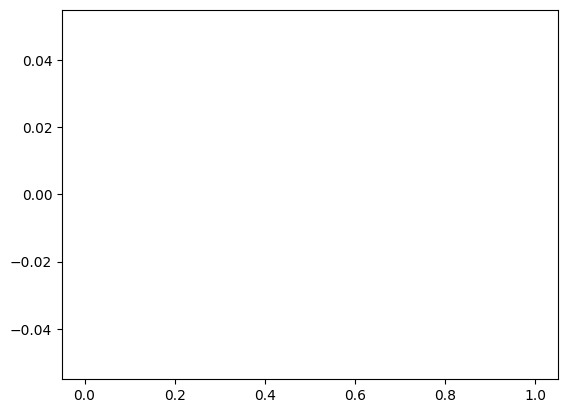

In [17]:
plt.hist(all_values, bins = 100)
plt.show()

In [25]:
for i in range(len(liedjesList)):
    for j in range(len(liedjesList)):
        if document_distance_matrix[i][j] > 0.98 and document_distance_matrix[i][j] < 0.99:
            print(document_distance_matrix[i][j])
            print(liedjesData[i])
            print(liedjesData[j])
            print("------------")


0.9827519127255391
['arnhem1849' 'arnhem1849-feestboekje1869' 'arnhem1849-feestboekje1869-08'
 'Geen fouten zetten!' 'Daar komt kleine Thomas aan' '1869' 'Een Bondslid'
 'arnhem1849']
['haarlem1851' 'haarlem1851-feestliederen1860'
 'haarlem1851-feestliederen1860-07' 'Feestlied' 'De Koning leef' '1860'
 'J.P. Nobels' 'haarlem1851']
------------
0.9866885933234839
['haarlem1851' 'haarlem1851-feestliederen1852'
 'haarlem1851-feestliederen1852-05' 'Costers eer!' 'Wien Neerlands bloed'
 '1852' '' 'haarlem1851']
['middelburg1847' 'middelburg1847-feestbundel1864'
 'middelburg1847-feestbundel1864-79' 'Tafelzang'
 'Als de boomen buiten bloeijen' '1863' '' 'middelburg1847']
------------
0.9827519127255391
['haarlem1851' 'haarlem1851-feestliederen1860'
 'haarlem1851-feestliederen1860-07' 'Feestlied' 'De Koning leef' '1860'
 'J.P. Nobels' 'haarlem1851']
['arnhem1849' 'arnhem1849-feestboekje1869' 'arnhem1849-feestboekje1869-08'
 'Geen fouten zetten!' 'Daar komt kleine Thomas aan' '1869' 'Een Bondsl

In [18]:
for i in range(len(liedjesList)):
    if document_distance_matrix[n][i] > 0.5:
        print(liedjesData[i])

['https://zotero.org/groups/2707622/items/I664294A' 'album1856-09'
 'HEIL DE KUNST' "Henri's drinklied" '1856' 'G. Nijman' 'denbosch1849']
['https://zotero.org/groups/2707622/items/I664294A' 'album1856-11'
 'BROEDERLIED VOOR TYPOGRAPHISCHE VEREENIGINGEN'
 'O groote koopman in tabak' '1856' 'M. Uitenbosch' 'haarlem1851']
['https://zotero.org/groups/2707622/items/I664294A' 'album1856-14'
 'COSTERS LOF' '' '1856' 'W.J. de Gruijter' 'denhaag1843']
['https://zotero.org/groups/2707622/items/I664294A' 'album1856-24'
 "DOOR EENDRAGT 'T ZAAM VERBONDEN" 'Wien Neerlands bloed' '1856' 'B. Kuit'
 'denhaag1843']
['https://zotero.org/groups/2707622/items/I664294A' 'album1856-35'
 'FEESTLIED' 'Wien Neerlands bloed' '1856' 'J.P. Nobels' 'haarlem1851']
['https://zotero.org/groups/2707622/items/I664294A' 'album1856-52'
 'DE UITVINDING DER BOEKDRUKKUNST. Cantate TE ZINGEN DOOR ALLE LEDEN DER TYPOGRAPHISCHE VEREENIGINGEN, BIJ HET STANDBEELD OF IN DEN HOUT, OP GEMAKKELIJKE EN MEEST BEKENDE ZANGWIJZEN.'
 '' 

In [19]:
# search for a term in the vocabulary
def find(searchterm):
    result = []
    i = 0
    term_index = -1

    for word in liedjesVocabulary:
        if liedjesVocabulary[i] == searchterm:
            term_index = i
        i = i + 1

    if term_index > -1:
        for j in range(len(liedjesList)):
            if dtm_liedjes[j][term_index] > 0:
                result.append(j)

    return result

In [20]:
print(find("magt"))

[8, 15, 17, 41, 52, 75, 129, 138, 142, 150, 182, 218, 286, 340, 350]
